In [4]:
import QUANTAXIS as QA

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 14  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import numpy as np

import seaborn as sns

from base.JuUnits import excute_for_multidates
from base.Constants import trade_date_sse, LOW_FREQUENCE

import pandas as pd

# import Ind_Ponding_VIX
# from ind.ind_base.Ind_PondingRate_VIX import PondingRate as Ind_Ponding_VIX
from ind.ind_base import Ind_PondingRate_VIX as Ind_Ponding_VIX
import dill
from base.JuUnits import parallal_task,task_chunk_split



def check_MA_above_multi(hy_tuple, self_obj):
    """计算均线以上的数量(for多进程)
       :param hy_tuple: (bloc_kname, hy_codes)
    """
    import QUANTAXIS as QA
    # from ind.ind_base.Ind_PondingRate_VIX import PondingRate as Ind_Ponding_VIX
    from ind.ind_base import Ind_PondingRate_VIX as Ind_Ponding_VIX
    import dill
    import pandas as pd
    import numpy as np
    from base.Constants import LOW_FREQUENCE
    
    self_ = dill.loads(self_obj)
    
    hy_codes = hy_tuple[1]
    bloc_kname = hy_tuple[0]
    
    try:
        if self_.frequence == QA.FREQUENCE.DAY:
            data = QA.QA_fetch_stock_day_adv(hy_codes, self_.start, self_.end)
        else:
            data = QA.QA_fetch_stock_min_adv(hy_codes, self_.start, self_.end,frequence=self_.frequence)
        data = data.data
#             data = data.to_hfq().data
    except Exception as e:
        print(e)
        return []

    if data is None:
        return []

    pr = Ind_Ponding_VIX.PondingRate(data)
    pr.change_pramas(window=20)
    pr.set_ignore_sub_ind(True)
    pr.fit()

    ind = pr.ind_df['main']
    count = len(hy_codes)
    compared = ind[(self_.MA-1)*count:] > ind.groupby(level=1, group_keys=False).apply(lambda x: QA.MA(x, self_.MA))[(self_.MA-1)*count:]
    if self_.frequence in LOW_FREQUENCE:
        date_label = 'date'
    else:
        date_label = 'datetime'
    res = compared.groupby(level=0).apply(lambda x: (x.index.get_level_values(date_label)[0], round(np.sum(x)/len(x),2)))   
    p = pd.DataFrame({date_label:[i[0] for i in res],'-':[i[1] for i in res]})
    return p.assign(blockname=bloc_kname)
    
class Block_Trend2:
    """
        1.展示每个行业，平均以上的股票占比图
        2.获取变化趋势
    """
    def __init__(self,hy_source='tdxhy', end='2021-04-30', gap=60, start=None, frequence=QA.FREQUENCE.DAY, MA=20):
        self._hy_source=hy_source
        self.end = end
        self.gap = gap
        self.MA = MA
        if start is None:
            self.start = trade_date_sse[trade_date_sse.index(end)-self.gap]
        else:
            self.start = start
        self.blocks_view = self.get_blocks_view()
        self.pivot = None
        self.frequence = frequence
        self.trend = None
        self.tmp =None
                
    @property
    def hy_source(self):
        return self._hy_source
    
    @hy_source.setter
    def hy_source(self, value):
        if not value in ['tdxhy','swhy','gn']:
            raise TypeError('hy_source MUST BE [tdxhy|swhy|gn]')
        self._hy_source=value
        self.blocks_view = self.get_blocks_view()
        
    @property
    def is_low_frequence(self):
        return self.frequence in LOW_FREQUENCE

    
    def fit(self, blocks=None):
        if blocks is None or blocks == 'all':
            ma_above = self.blocks_view.apply(self.check_MA_above)
        elif isinstance(blocks, list):
            ma_above = self.blocks_view[blocks].apply(self.check_MA_above)
        else:
            raise TypeError('fit(blocks) params error')
        tmp = ma_above.reset_index()
        self.tmp = tmp
        if self.is_low_frequence:
            date_label = 'date'
        else:
            date_label = 'datetime'
        rebuid_df = pd.DataFrame({'blockname':tmp.blockname.repeat(tmp[0].str.len()),date_label:[i[0] for i in np.concatenate(tmp[0].values)],'-':[i[1] for i in np.concatenate(tmp[0].values)]})
        self.pivot = rebuid_df.pivot(index=date_label, columns='blockname')
        print('pivot fit finish')
        
        
    def fit_multi(self, blocks='all',worker=4):
        assert blocks=='all','多进程仅允许全block，单一block没意义'
        
        task = [x for x in self.blocks_view.items()]
                
        results = parallal_task(worker, check_MA_above_multi, task, self_obj=dill.dumps(self))
        tmp = pd.concat(results)
        self.tmp = tmp
        
        if self.is_low_frequence:
            date_label = 'date'
        else:
            date_label = 'datetime'
            
        self.pivot = tmp.pivot(index=date_label, columns='blockname')
        print('pivot fit finish')
        
    def get_blocks_view(self):
        a = QA.QA_fetch_stock_block_adv().data
        blocks_view = a[a['type'] == self._hy_source].groupby(level=0).apply(
            lambda x:[item for item in x.index.remove_unused_levels().levels[1]]
        )
        return blocks_view
    
    def check_MA_above(self, hy_codes):
        """计算均线以上的数量"""
        try:
            if self.frequence == QA.FREQUENCE.DAY:
                data = QA.QA_fetch_stock_day_adv(hy_codes, self.start, self.end)
            else:
                data = QA.QA_fetch_stock_min_adv(hy_codes, self.start, self.end,frequence=self.frequence)
            data = data.data
#             data = data.to_hfq().data
        except Exception as e:
            print(e)
            return []
        
        if data is None:
            return []
        
        pr = Ind_Ponding_VIX.PondingRate(data)
        pr.change_pramas(window=20)
        pr.set_ignore_sub_ind(True)
        pr.fit()

        ind = pr.ind_df['main']
        count = len(hy_codes)
        compared = ind[(self.MA-1)*count:] > ind.groupby(level=1, group_keys=False).apply(lambda x: QA.MA(x, self.MA))[(self.MA-1)*count:]
        if self.is_low_frequence:
            date_label = 'date'
        else:
            date_label = 'datetime'
        res = compared.groupby(level=0, group_keys=False).apply(lambda x: (x.index.get_level_values(date_label)[0], round(np.sum(x)/len(x),2)))
        return res.values
    
    def JCSC(self, ma=20):
        return self.pivot.apply(lambda x: QA.CROSS(x,QA.MA(x,ma))+QA.CROSS(QA.MA(x,ma),x)*-1, axis=0)
    
    def get_trend(self, window=3, absolute=False, plot=False):
        if absolute:
            self.trend = self.pivot.apply(lambda x: round((x-x.shift(window))/x.shift(window),2), axis=0)
            if plot: self.draw_plot(trend, cmap='coolwarm',vmin=-0.8, vmax=0.8)     
        else:
            trend = self.pivot.rolling(3).apply(lambda y:round(np.polyfit(np.linspace(1,3,3),y,1)[0],2))
            self.trend = trend.rolling(2).apply(lambda x:x[1]-x[0])
            
        if plot:
            stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
            xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]

            block_count = len(self.trend.columns)
            if block_count > 100:
                self.draw_plot(self.trend.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)], cmap='coolwarm',vmin=-0.3, vmax=0.3)
                self.draw_plot(self.trend.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count], cmap='coolwarm',vmin=-0.3, vmax=0.3)
            else:
                self.draw_plot(trend, cmap='coolwarm',vmin=-0.3, vmax=0.3)
        return self.trend
    
    def get_trend_rank(self, date_str=None):
        if self.trend is None:
            self.get_trend()
        if date_str is None:
            return self.trend.iloc[-1].rank(ascending=False,method='first').sort_values()
        if not isinstance(date_str, str):
            raise TypeError('date_str MUST BE str')
        return self.trend.loc[date_str].rank(ascending=False,method='first').sort_values()
    
    def plot(self):
        stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
        xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]

        block_count = len(self.pivot.columns)
        
        if block_count > 100:
            # 如果板块过多，分成两张表
            # 非modin可以不处理xlabel
            self.draw_plot(self.pivot.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)])
            self.draw_plot(self.pivot.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count])
        else:
            self.draw_plot(self.pivot, xlabel)
    
    def draw_plot(self,data,xlabel=None,cbar=True,cmap='coolwarm',vmin=None, vmax=None):
        width = 40*len(data.columns)
        high = 15*len(data.index)
        if width > 2100:width = 2100
        if high < 520:high = 520
        
        formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
        ylabel = [pd.to_datetime(x).strftime(formater) for x in self.pivot.index.values]
        
        fig = plt.figure(figsize=(width/72,high/72))
        if xlabel is None:
            sns.heatmap(data,fmt='.2f', yticklabels=ylabel,
                         linewidths=0.5,cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            sns.heatmap(data,fmt='.2f', yticklabels=ylabel, xticklabels=xlabel, 
                         linewidths=0.5,cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(rotation = -90)
        plt.show()


pivot fit finish


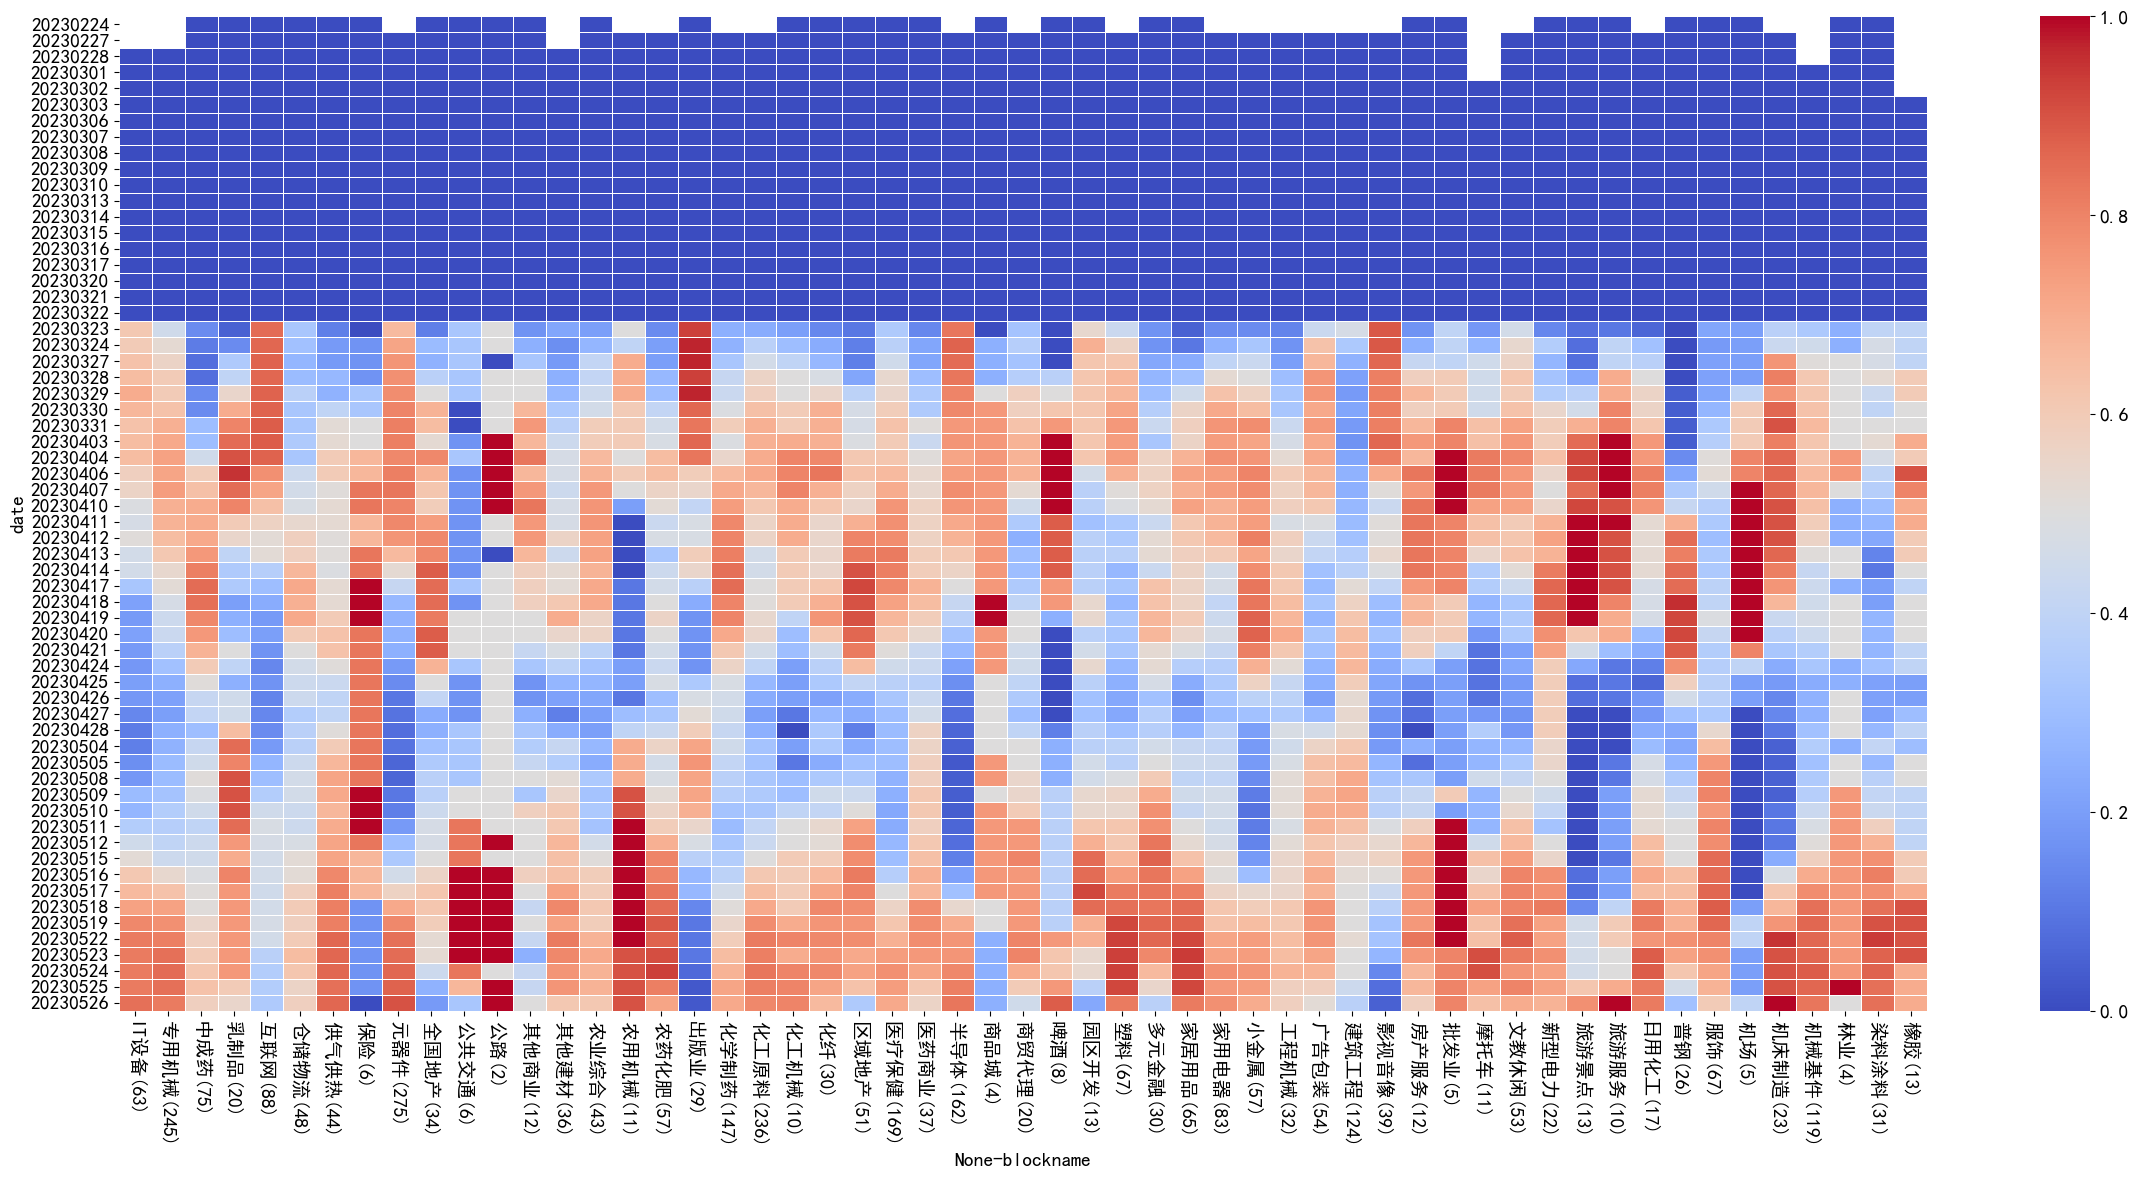

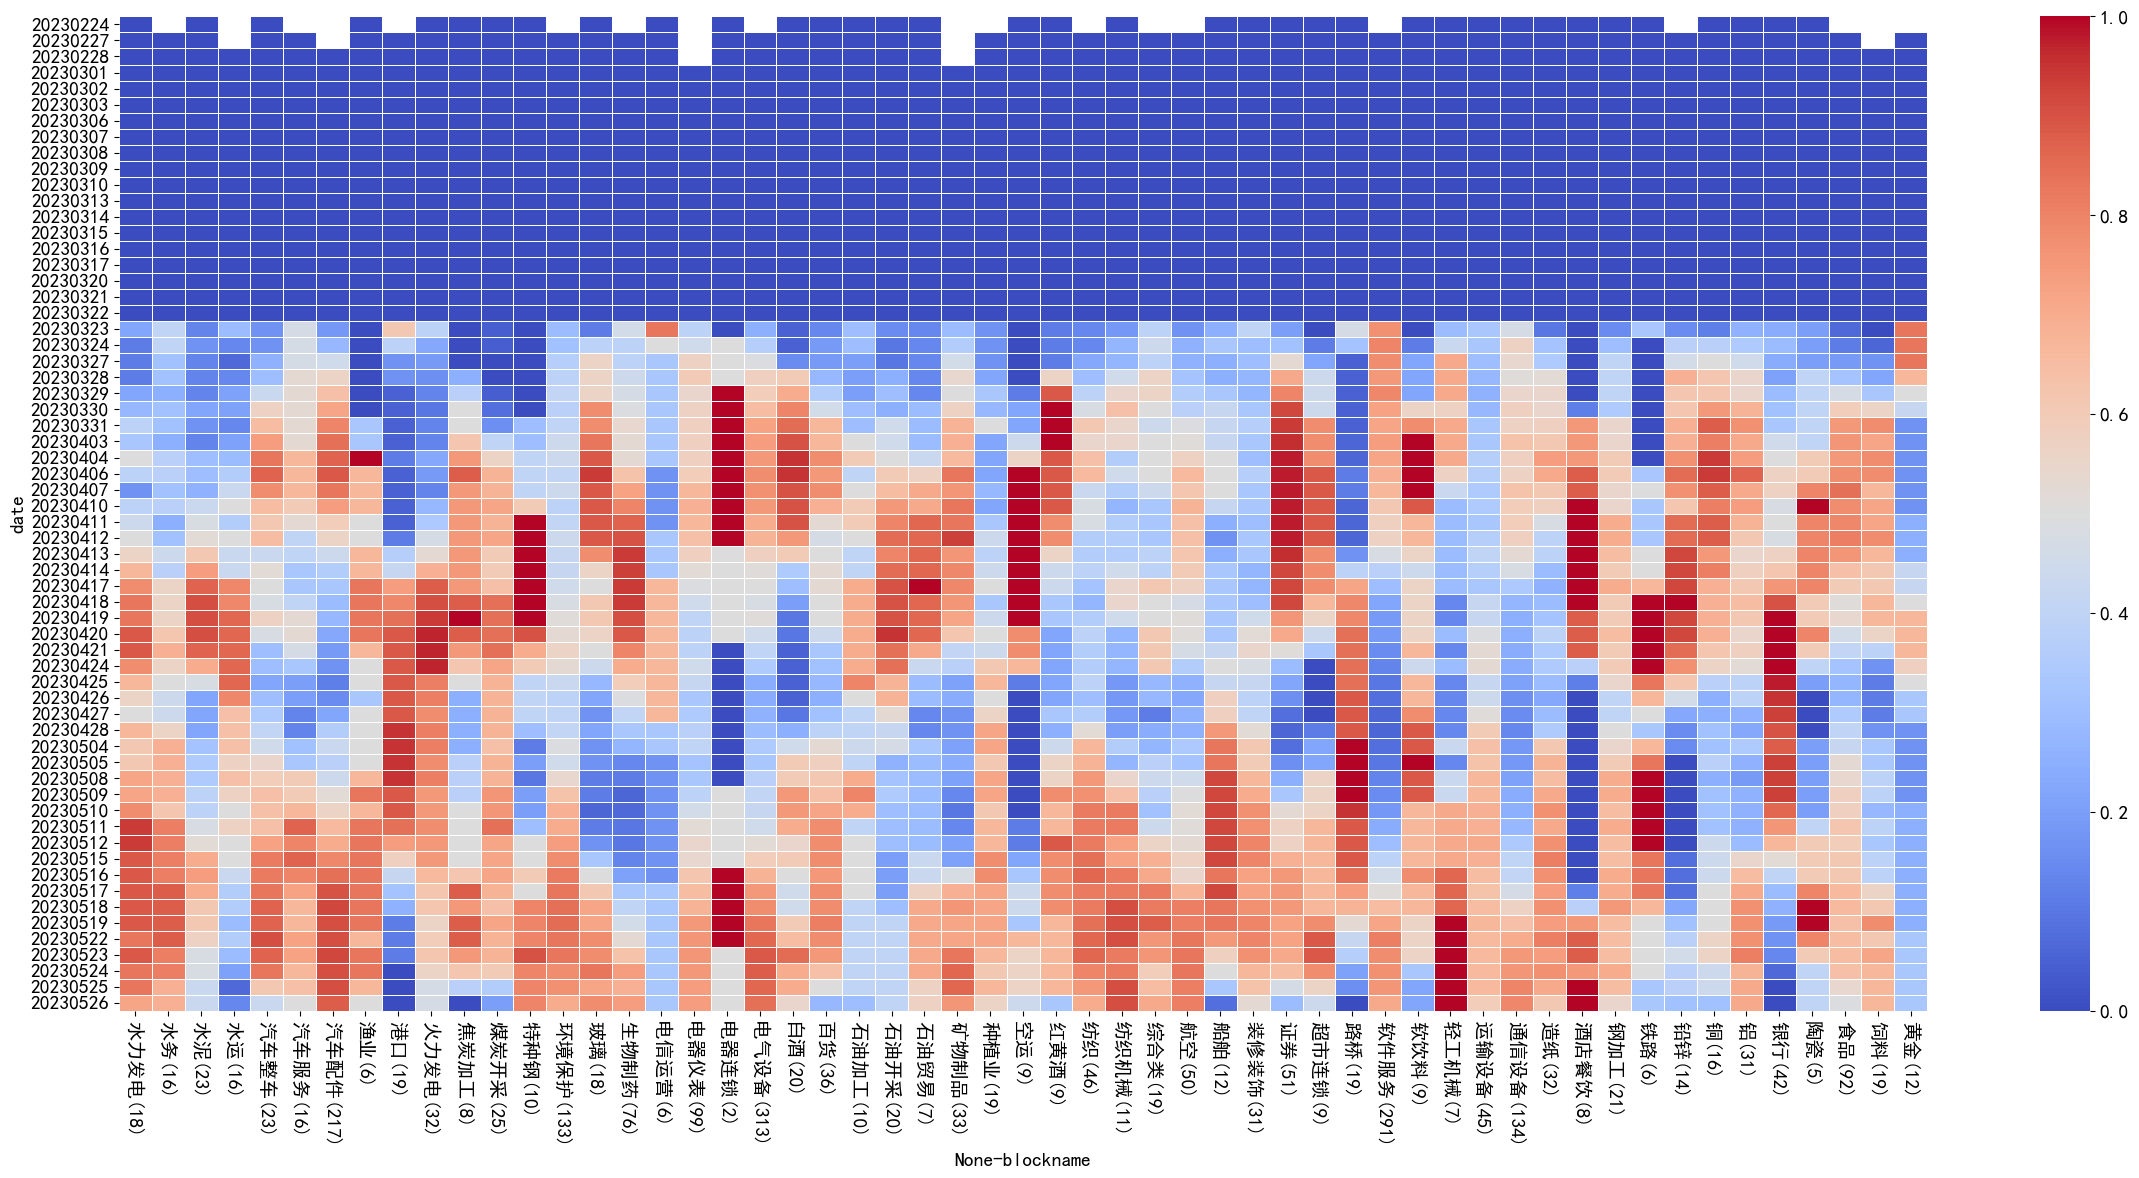

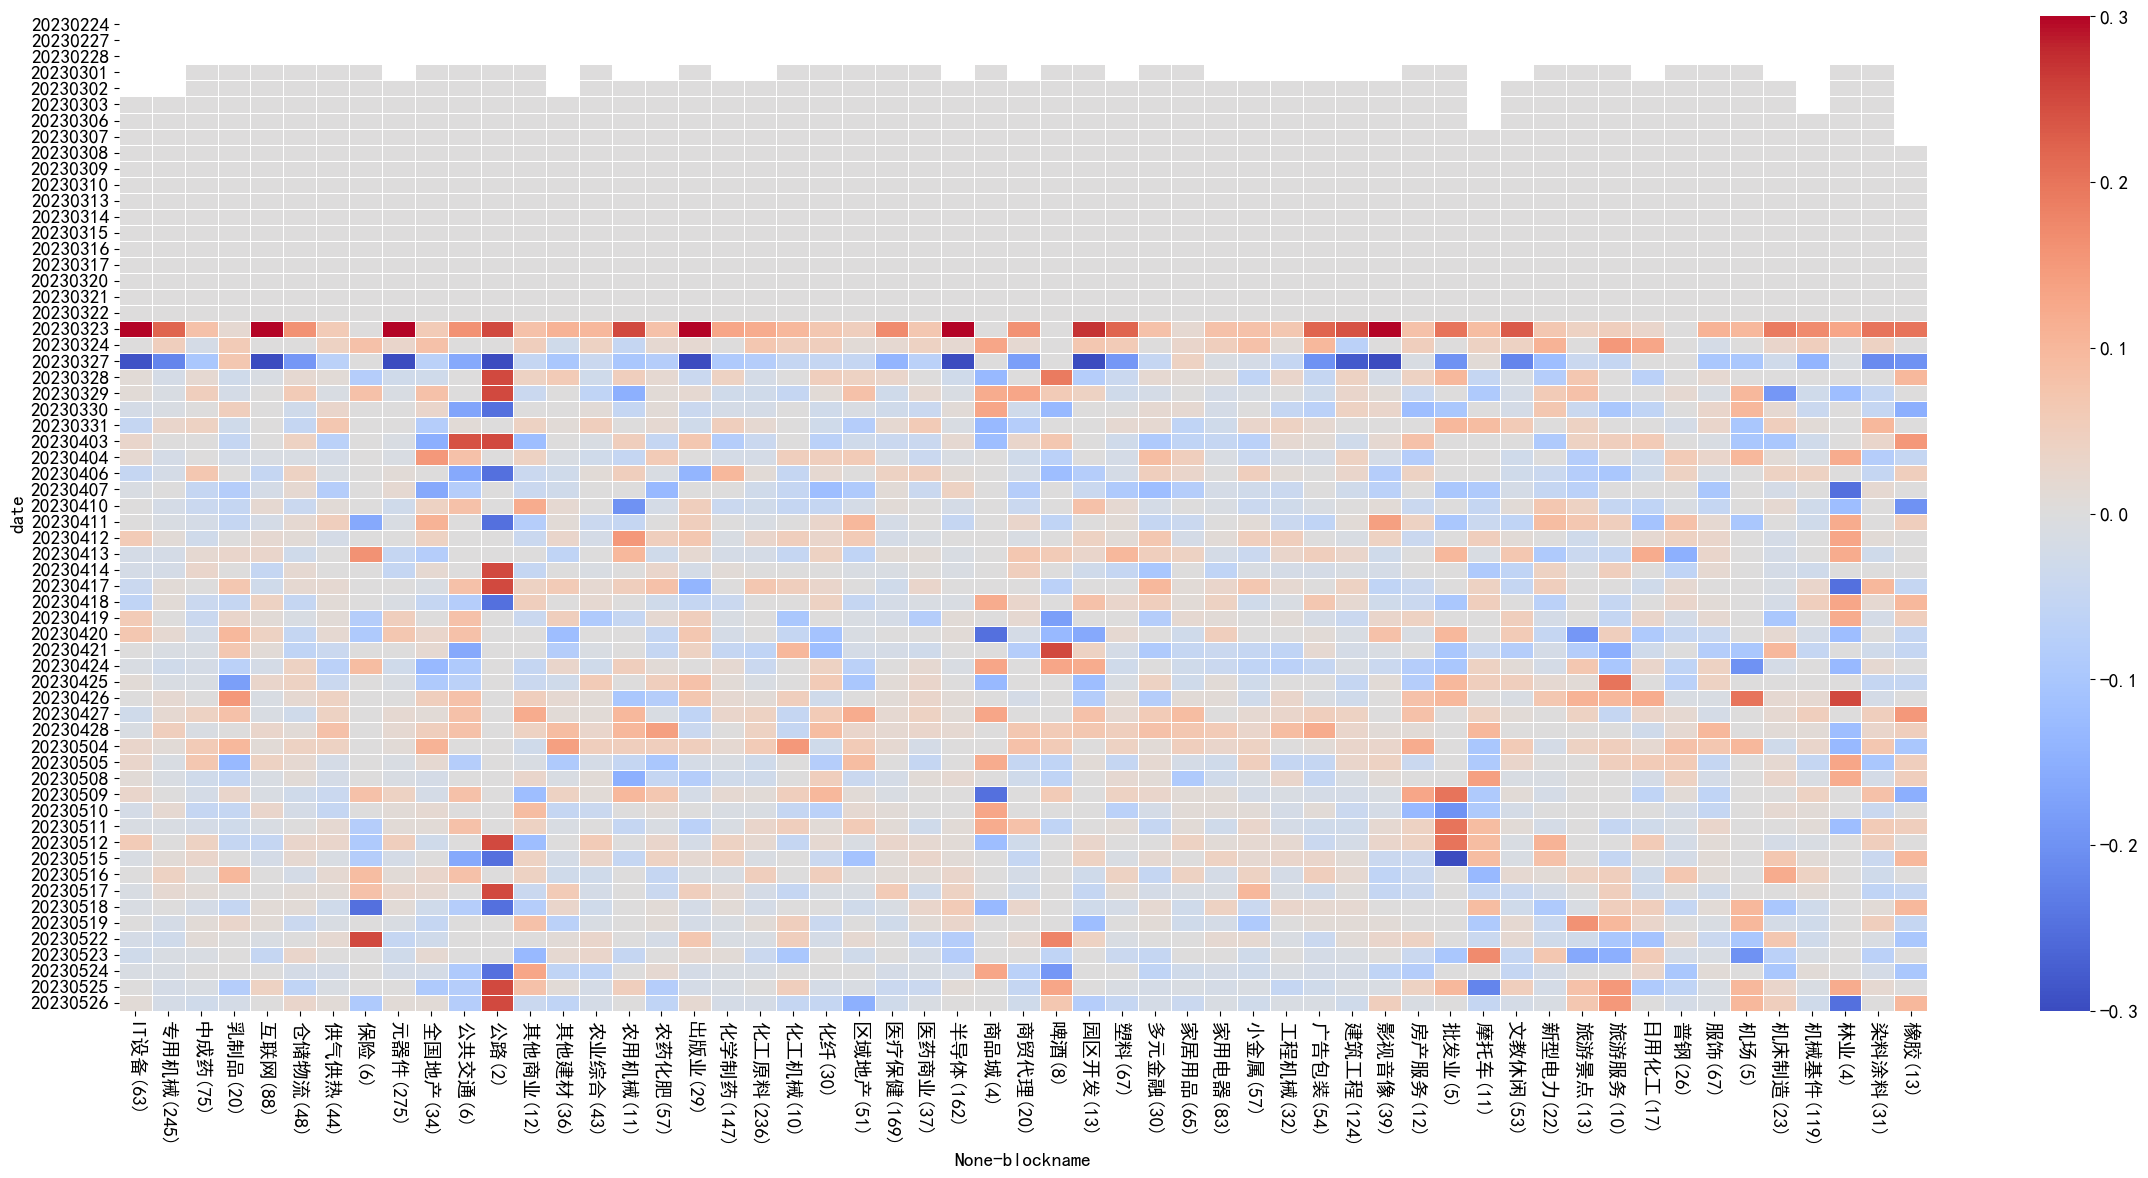

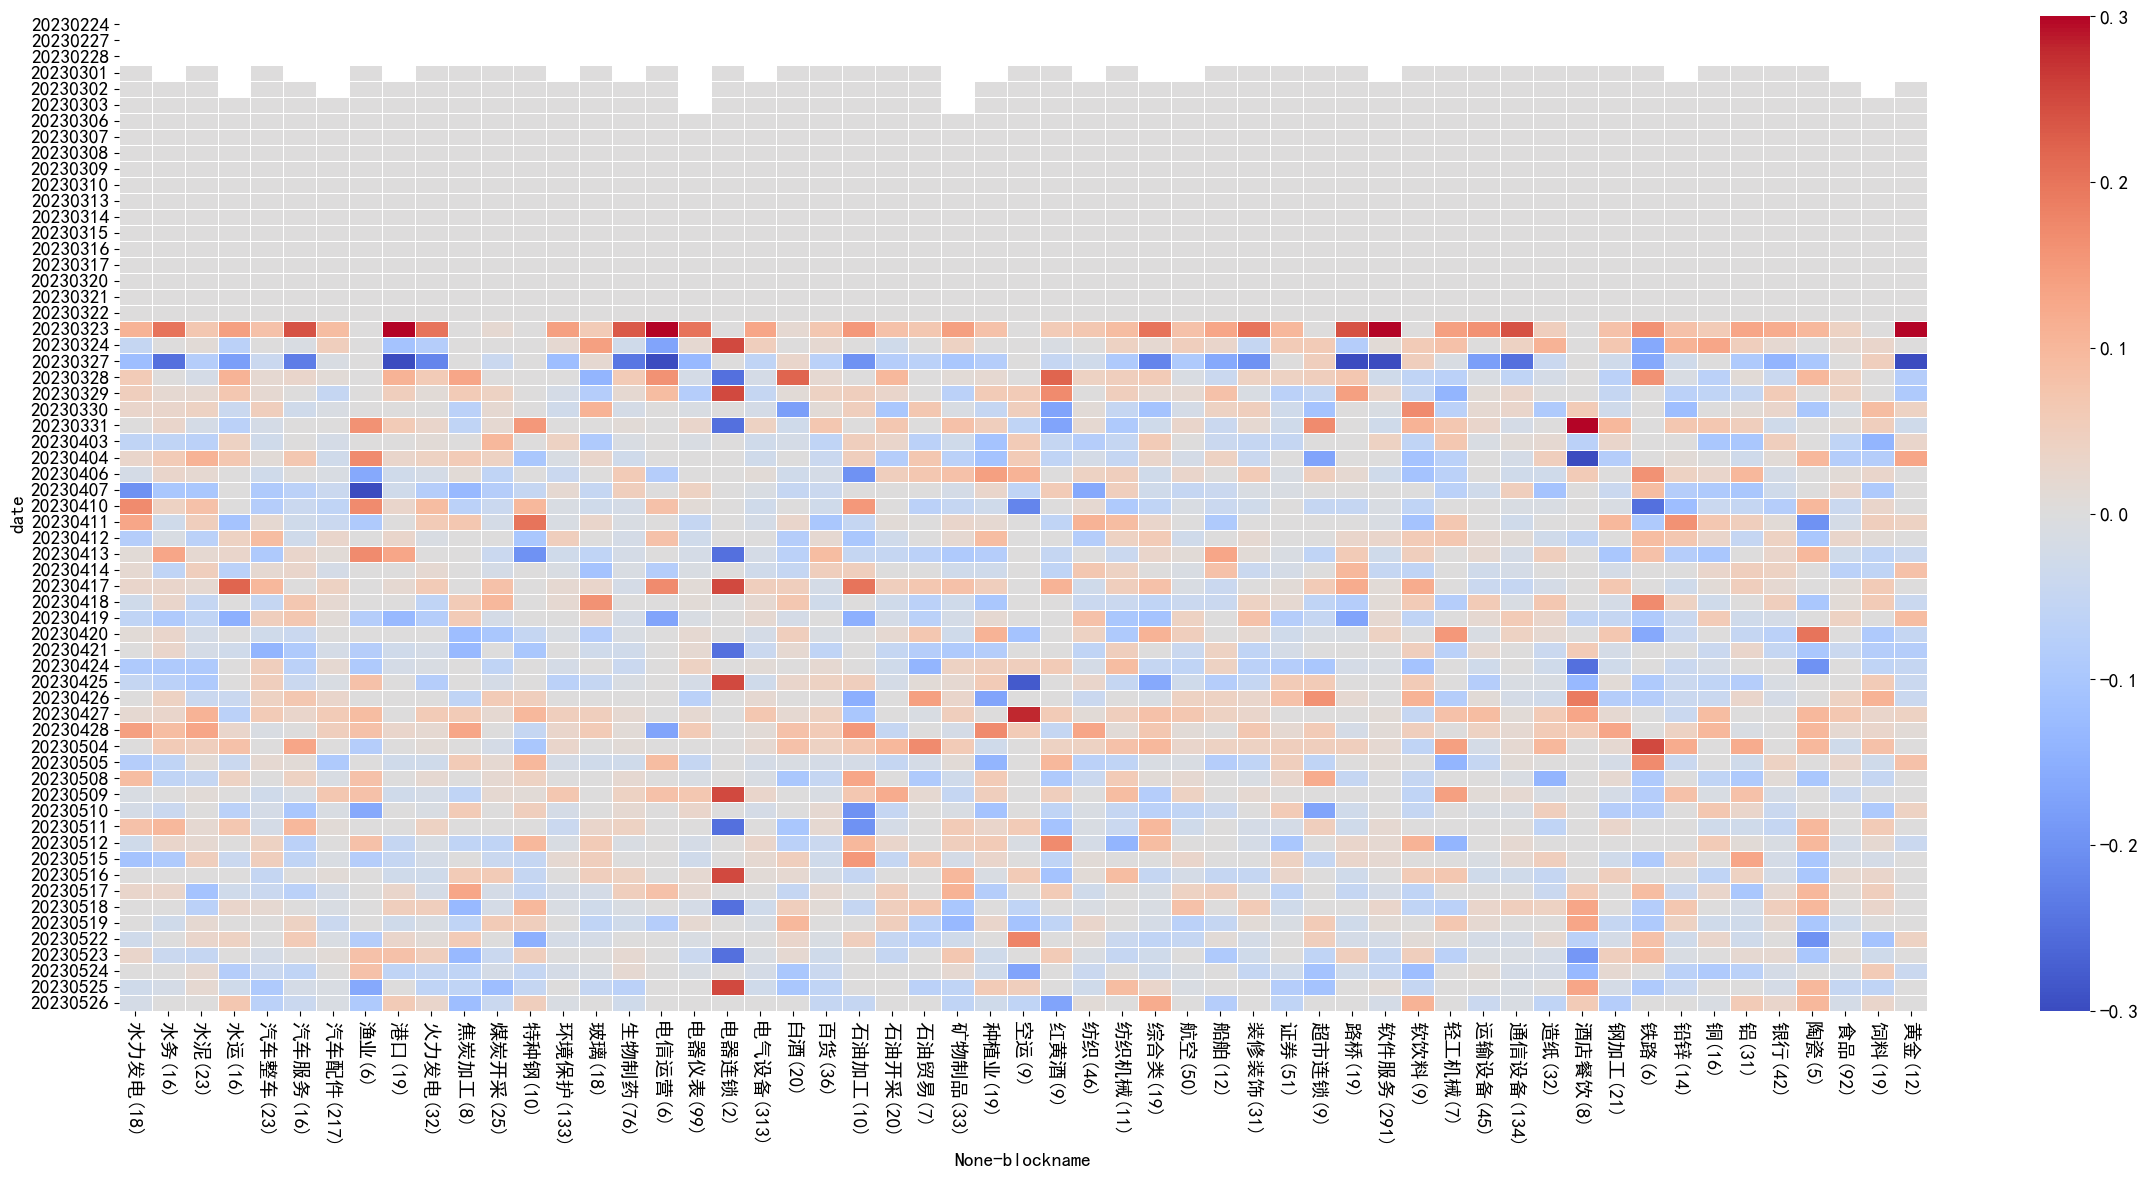

CPU times: user 1min 2s, sys: 36.6 s, total: 1min 38s
Wall time: 50.5 s


In [6]:
%%time
hy = Block_Trend2(hy_source='tdxhy',end='2023-05-26', gap=80, frequence=QA.FREQUENCE.DAY)
# hy.fit_multi()
hy.fit()

hy.plot()
tr_hy = hy.get_trend(window=5,absolute=False,plot=True)


In [6]:
hy.pivot
# hy.trend(absolute=True)

-                                                        ...  \
blockname   IT设备  专用机械   中成药   乳制品   互联网  仓储物流  供气供热    保险   元器件  全国地产  ...   
date                                                                    ...   
2021-06-09  0.00   NaN  0.00  0.00  0.00   NaN   NaN  0.00   NaN  0.00  ...   
2021-06-10  0.00  0.00  0.00  0.00  0.00  0.00   NaN  0.00  0.00  0.00  ...   
2021-06-11  0.00  0.00  0.00  0.00  0.00  0.00   NaN  0.00  0.00  0.00  ...   
2021-06-15  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...   
2021-06-16  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2021-08-30  0.44  0.68  0.49  0.38  0.57  0.76  0.54  0.22  0.56  0.62  ...   
2021-08-31  0.31  0.57  0.53  0.31  0.51  0.68  0.44  0.11  0.47  0.56  ...   
2021-09-01  0.33  0.42  0.54  0.38  0.56  0.66  0.23  0.56  0.36  0.59  ...   
2021-09-02  0.36  0.37  0.56  0.44  0.61  0.61  0.26  0.89  0.31  0.62  ...   
2021-09-03  0.38  0.27  0.61  0.38  0.58  0.51  0.15  0.89  0.29  0.65  ...   

                                                                       
blockname    钢加工   铁路    铅锌     铜     铝    银行    陶瓷    食品    饲料    黄金  
date                                                                   
2021-06-09  0.00  0.0  0.00  0.00  0.00   NaN  0.00  0.00  0.00   NaN  
2021-06-10  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
2021-06-11  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
2021-06-15  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
2021-06-16  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
...          ...  ...   ...   ...   ...   ...   ...   ...   ...   ...  
2021-08-30  0.78  1.0  1.00  0.94  0.91  0.10  0.71  0.38  0.12  0.54  
2021-08-31  0.67  0.8  1.00  0.88  0.91  0.07  0.71  0.34  0.19  0.69  
2021-09-01  0.56  1.0  1.00  0.75  0.88  0.37  0.57  0.35  0.19  0.54  
2021-09-02  0.41  1.0  0.77  0.69  0.75  0.61  0.43  0.32  0.38  0.54  
2021-09-03  0.41  1.0  0.69  0.62  0.53  0.68  0.29  0.34  0.56  0.54  

[62 rows x 110 columns]

In [3]:
%%time
gn = Block_Trend2(hy_source='gn',end='2021-09-10', gap=80, frequence=QA.FREQUENCE.DAY)
gn.fit_multi()
gn.plot()
tr_gn = gn.get_trend(window=5,absolute=False,plot=True)

Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:2660  pid:2320


/tmp/ipykernel_2660/3482049328.py:130: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  task = [x for x in self.blocks_view.iteritems()]


: 

: 